<a href="https://colab.research.google.com/github/etalab-ia/ami-ia/blob/master/notebooks/ami_ia_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook NLP

Introduction au NLP avec l'example des avis rendus par la CADA (Comission d'Accès aux Documents Administratifs)
L'objectif de ce notebook est présenter des exemples d'utilisation de modèles de traitement du langage naturel, à partir d'un jeu de données textuelles. Nous allons analyser les avis CADA et tenter de répondre à deux questions: 

### 1- Puis-je dégager les thèmes principaux traités par les avis CADA? 
### 2 - Puis-je classer automatiquement les avis en avis Favorable / Défavorable à partir du texte de l'avis? 

Concernant la première question, on se met dans la peau d'un agent de la CADA, qui doit faire un rapport présentant les principaux thèmes abordés dans les avis CADA, et la proportion représentée par chacun de ces thèmes. 

Concernant la deuxième question, l'intérêt de ce type d'analyse serait de vérifier automatiquement la cohérence des métadonnées. Est-ce qu'un avis classé dans le SI comme favorable correspond bien à un avis défavorable au regard du texte de l'avis. 


A la fin du notebook, on présente quelques étapes classiques de traitement de langage naturel. 

La page de data.gouv où l'on peut télécharger les données est ici: https://www.data.gouv.fr/fr/datasets/avis-et-conseils-de-la-cada/ . L'url de téléchargement des données utilisées ici est https://www.data.gouv.fr/fr/datasets/r/93aed7ce-db2f-4982-8127-340562061e4b . 

## Partie 0: Analyses simples du jeu de données 

importation des libraries utiles

In [1]:
# pour la manipulation de jeux de données 
import pandas as pd
import numpy as np

# commandes pour éliminer les warnings 
import warnings
warnings.filterwarnings("ignore")

# pour la dataviz 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Lecture du jeu de données à partir de l'url 

In [6]:
# lire le jeu de données en un objet "pandas dataframe"
# (ici on a coupé le jeu de données en 2 parties), on lit chacun des deux parties puis on les concatène 
df1 = pd.read_csv('https://raw.githubusercontent.com/etalab-ia/ami-ia/master/session2/data/cada-2020-05-12_part1.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/etalab-ia/ami-ia/master/session2/data/cada-2020-05-12_part2.csv')
df = pd.concat([df1, df2])

Quel est le nombre de lignes et le nombre de colonnes de mon jeu de données ? 

In [7]:
df.shape

(38287, 11)

Quels sont les types des colonnes mon jeu de données? 

In [8]:
df.dtypes

Numéro de dossier       int64
Administration         object
Type                   object
Année                   int64
Séance                 object
Objet                  object
Thème et sous thème    object
Mots clés              object
Sens et motivation     object
Partie                 object
Avis                   object
dtype: object

A quoi ressemble mon jeu de données ? 

In [6]:
df.head()

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...


On regarde les variables catégorielles: 
- combien de valeurs remplies (count), 
- combien de valeurs uniques / modalités (unique), 
- quelle est la modalité la plus représentée (top), 
- quelle est le nombre de fois où apparait la modalité la plus représentée (freq)

In [7]:
df.describe(include = np.object)

,Administration,Type,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
count,38286,38287,38287,38270,38206,33125,38271,36059,38286
unique,12850,3,569,35334,828,3615,3094,4,37519
top,Direction générale des finances publiques (DGFIP),Avis,31/12/2017,"Communication, par envoi postal ou par courrie...",Travail Et Emploi / Emploi Public,Marché public,Favorable,III,"Monsieur X, pour l’association Regards citoyen..."
freq,1255,35562,1450,556,3025,1838,11407,31429,132


### Visualisation du nombre d'avis par année

on crée une dataframe avec une ligne par année, la colonne count donne le nombre d'avis par année 


In [8]:
df["count"] = 1
dfg = df.groupby("Année").agg("sum").reset_index()

Text(0.5, 1.0, "Nombre d'avis CADA par année")

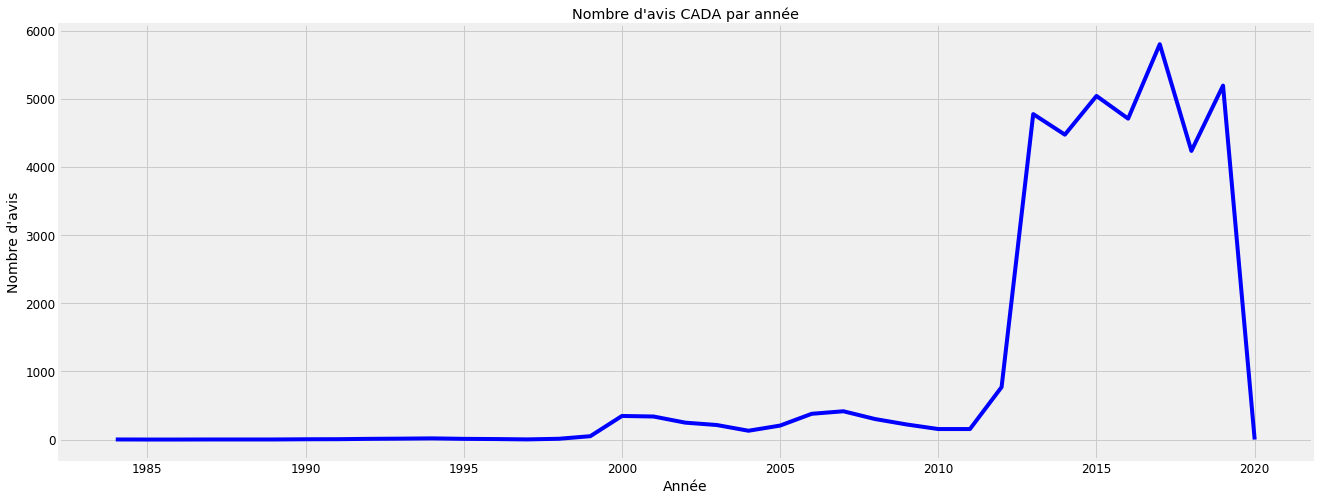

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(dfg['Année'], dfg['count'], 'b-')
plt.xlabel('Année'); plt.ylabel("Nombre d'avis"); plt.title("Nombre d'avis CADA par année")

On remarque qu'il y a très peu d'avais avant 2012, et donc que la majorité des avis sont pour la période 2012-2020
Commbien d'avis sont compris dans cette période 2012-2020? 

In [10]:
print("Nombre d'avis dans 20012-2020 :  {}".format(len(df[df["Année"].isin(range(2012, 2020))])))
print("Proportion d'avis dans 20012-2020 :  {}".format(len(df[df["Année"].isin(range(2012, 2020))])/len(df)))

Nombre d'avis dans 20012-2020 :  35024
Proportion d'avis dans 20012-2020 :  0.9147752500848852


# Partie 1 : topic extraction (non supervisé)


## Un algorithme d'extraction de topiques: LDA (Latent Dirichlet Allocation) 

### ressource : article très pédagogique (en anglais) dont on s'inspire ici https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc 

### A quoi sert cet algorithme?
 
LDA est un algorithme d'extraction de topics. A partir d'un corpus de documents, il permet de : 
- définir un nombre de topics (un topic est caractérisé par une liste de mots)
- attribuer à chaque document un ou des topics de la liste de topics trouvés par l'algorithme 



![illustration_LDA.png](./images/illustration_LDA.png)

### Quel est l'intérêt pour l'analyse des données CADA? 

Dans le jeu de données, nous avons la colonne "Thème et sous thème". On se met dans la situation où on a perdu cette colonne (pour tout ou une partie des données). On a besoin d'avoir une idée des thématiques abordées dans les avis rendus par la CADA. Une analyse automatique nous permet de réaliser cet objectif. 


In [11]:
# Etape 0 : importation de la librairie avec l'algorithme 
#!pip install gensim si ce n'est pas déjà fait 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim import models
from gensim.models import Phrases
from gensim import corpora

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimmontalibet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimmontalibet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Etape 1 :préparation et nettoyage des données textuelles 

- tokenization 
- supression de la ponctuation (pour certains cas d'usage, il peut cependant être utile de garder la ponctuation)


Pour la tokenisation, nous l'avons déjà calculée dans la partie 1 (les tokens sont dans la colonne "avis_word_token". 
On supprime la ponctuation avec la commande ci-desous

In [14]:
# on retire les Avis "vides"
df = df.dropna(subset = ["Avis"]) 
# on tokenize 
df["avis_word_token"] = df["Avis"].map(lambda x : word_tokenize(x.replace("'", " "))) # on remplace les appostrophes par un espaces
# car la tokenization avec la fonction "word_tokenize" de nltk ne les sépare pas autrement 
df["avis_word_token"] = df["avis_word_token"].map(lambda list_word: [word.lower()  for word in list_word if word.isalpha()])

On supprime les stopwords (les mots très courants et qui n'apporte pas d'information spécifique pour caractériser le thème du document)
Pour cela, on utilise une liste prédéfinie de stopwords de la librairie nltk, que l'on complète avec un certain nombre de stopwords. 


In [15]:
# création de la liste de stopwords
custom_stopwords = ["a", "dont", "madame", "monsieur", "peut", "dès", "lors", "être", "ce",
                    "ces", "cet", "cette", "comme", "ainsi", "si"]
stopwords_fr = stopwords.words('french') + custom_stopwords
print(len(stopwords_fr))
#print(stopwords_fr)

# on enlève les stopwords
df["avis_word_token"] = df["avis_word_token"].map(lambda list_word: [word for word in list_word if word not in stopwords_fr])


172


On regarde ce que ça donne (différence entre notre document initial et la liste des tokens "netoyés"). 
Vous pouvez changer le numero_doc (modifier le chiffre après le = ) et exécuter la cellule pour visualiser un autre document du corpus

In [16]:
numero_doc = 0

print("Document initial")
print(df.loc[numero_doc, "Avis"])
print("\n")
print("Document tokénisé")
print(df.loc[numero_doc, "avis_word_token"])
print("\n")
print("Nombre de token dans le doc :{}".format(len(df.loc[numero_doc, "avis_word_token"])))

Document initial
La commission d'accès aux documents administratifs a examiné dans sa séance du 3 mars 1984 la demande dont vous l'avez saisie par lettre du 21 décembre 1983.

La commission a émis un avis défavorable à la communication du dossier d'enquête relatif au refus de votre admission en qualité d'élève-officier de réserve interprète et du chiffre de la Marine, au motif qu'elle porterait atteinte au secret de la défense nationale, exception prévue par l'article 6 de la loi du 17 juillet 1978.


Document tokénisé
['commission', 'accès', 'documents', 'administratifs', 'examiné', 'séance', 'mars', 'demande', 'saisie', 'lettre', 'décembre', 'commission', 'émis', 'avis', 'défavorable', 'communication', 'dossier', 'enquête', 'relatif', 'refus', 'admission', 'qualité', 'réserve', 'interprète', 'chiffre', 'marine', 'motif', 'porterait', 'atteinte', 'secret', 'défense', 'nationale', 'exception', 'prévue', 'article', 'loi', 'juillet']


Nombre de token dans le doc :37


#### Etape 2: Entrainement de l'algorithme 

Dans l'étape ci-dessous, nous allons, à partir de notre liste de tokens netoyés, créer des bigrammes. Les bigrammes sont des paires de mots, qui peuvent être porteurs de sens et qui sont donc utile pour le topic extraction. 


In [17]:
# création des tokens avec bigrammes 
tokens = df['avis_word_token'].tolist()
bigram_model = Phrases(tokens)
tokens = list(bigram_model[tokens])

Entrainement du modèle après avoir constitué: 
- le dictionnaire des mots du corpus (ici les tokens "simples" (monogrammes) et bigrammes )
- le corpus au format spécique du modèle LDA de gensim 

In [18]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]



# les inputs : le corpus de documents tokenizé et le dictionnaire 
# (liste des mots apparaissant dans le dictionnaire)

np.random.seed(123456)
num_topics = 15
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 3min 2s, sys: 1.21 s, total: 3min 3s
Wall time: 1min 37s


#### Etape 3 : Visualisation des topics 

Dans un premier temps, on peut visualiser les topics de façon très "brute" sous forme de listes de termes qui caractérisent chaque topic. L'interprétation de ces topics demande une réfléxion "humaine" pour les rendre intelligibles. 

In [19]:
# avec 15 topics 
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.022*"point" + 0.017*"document" + 0.013*"relations_entre" + 0.010*"suite" + 0.009*"réponse" + 0.008*"points" + 0.008*"droit" + 0.008*"avis" + 0.008*"agissant" + 0.008*"ministre"

1: 0.031*"relations_entre" + 0.023*"personne" + 0.022*"mentions" + 0.022*"communicables" + 0.018*"porterait_atteinte" + 0.018*"estime" + 0.017*"préjudice" + 0.016*"privée" + 0.016*"communicable" + 0.015*"sécurité"

2: 0.035*"droit" + 0.022*"dossier" + 0.021*"qualité" + 0.020*"médical" + 0.016*"santé_publique" + 0.015*"dossier_médical" + 0.014*"informations_médicales" + 0.014*"défunt" + 0.014*"demandeur" + 0.014*"personne_décédée"

3: 0.025*"relations_entre" + 0.023*"maire" + 0.020*"fait" + 0.019*"toute_personne" + 0.017*"communicables" + 0.014*"commune" + 0.014*"émet_donc" + 0.013*"estime" + 0.010*"articles" + 0.010*"sous_réserve"

4: 0.039*"dossier" + 0.027*"relations_entre" + 0.019*"communicables" + 0.018*"droit" + 0.015*"administratifs" + 0.015*"dispositions" + 0.014*"sécurité_sociale" + 0.013*"procédur

Exemples d'interprétation des topics ci-dessus:
- topic 0: difficile à interpréter, topic un peu "fourre-tout"
- topic 1: relation entre administration et personnes privées
- topic 2: dossiers médicaux 
- topic 3: mairie et conseil municipal 
- topic 4: sécurité sociale 
- topic 5: santé publique 
etc...

#### Etape 4 : Attribution des topics aux documents 


In [20]:
# pour un document
print(lda_model[corpus[0]])

# pour tous les documents, on crée une colonne topic number 
df["topic_list"] = [lda_model[i] for i in corpus]
# la commande ci dessus nous permet, pour chaque document, d'obtenir une liste de topics avec les probabilités associées 
# que chaque document appartienne 
df["main_topic"] = df["topic_list"].map(lambda list_topic: list_topic[0][0])
df["main_topic_proba"] = df["topic_list"].map(lambda list_topic: list_topic[0][1])

[(1, 0.20341153), (3, 0.24806829), (10, 0.07011849), (12, 0.17497297), (13, 0.29927886)]


In [21]:
df.head()

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis,count,avis_word_token,topic_list,main_topic,main_topic_proba
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...,1,"[commission, accès, documents, administratifs,...","[(1, 0.20349617), (3, 0.24827641), (10, 0.0700...",1,0.203496
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...,1,"[commission, accès, documents, administratifs,...","[(0, 0.25220433), (1, 0.047230873), (3, 0.1926...",0,0.252204
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...,1,"[commission, accès, documents, administratifs,...","[(0, 0.1729052), (10, 0.39351776), (11, 0.1330...",0,0.172905
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...,1,"[commission, accès, documents, administratifs,...","[(3, 0.14169867), (4, 0.12759621), (10, 0.1081...",3,0.141699
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...,1,"[commission, accès, documents, administratifs,...","[(0, 0.59537977), (1, 0.10921103), (3, 0.10284...",0,0.595380


In [22]:
df["nombre_documents"] = 1
df_topic = df.groupby(["main_topic"])["nombre_documents"].count().sort_values(ascending = False).reset_index()
df_topic

,main_topic,nombre_documents
0,0,18918
1,3,7281
2,1,5974
3,2,2005
4,4,1628
5,7,1346
6,5,666
7,6,211
8,9,104
9,10,78


#### Etape 5 : Eventuellement retour à l'étape 1 (en modifiant les étapes de netoyages) et 2 (en testant différents paramètres, avec en particulier le nombre de topics)


#### Etape 6: Visualisation interactive des topics avec la librairie pyLDAvis


In [23]:

%matplotlib inline
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim


/Users/kimmontalibet/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [24]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
%time  pyLDAvis.display(vis)

CPU times: user 7.88 ms, sys: 461 µs, total: 8.34 ms
Wall time: 8.35 ms


# Partie 2 :  prédiction de la conclusion de la décision à partir du texte de l'avis 

La partie précédente présentait un exemple de modèle non supervisé à partir de données textuelles. Des modèles non supervisés ont l'avantage de pouvoir être entrâiné à partir d'un ensemble de documents textuels "bruts". 
Nous présentons ici un exemple de modèle non supervisé. Il faut alors, en plus du texte brut, avoir une variable "à prédire". Dans beaucoup de cas, cette variable "à prédire" n'est pas directement disponible et il faut la construire (en annotant ou labelisant à la main les documents). Ici nous allons considérer la variable "Sens et motivation", qui renseigne la conclusion de l'avis rendu par la Cada. Nous allons voir si nous arrivons à entraîner un modèle à prédire, à partir du texte de la décision, à prédire la conclusion de l'avis. 

L'intérêt: on peut imaginer que le "Sens et motivation" est parfois renseigné de façon erronée et donc vérifier de façon automatique la cohérence de ce qui est renseigné. 

In [ ]:
# librairies de machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#### Première étape: simplifier la colonne "sens et motivation" en un petit nombre de catégorie

La colonne "Sens et motivation" comporte 3094 modalités (valeurs distinctes) comme vu dans la partie 0 de description des données. Etant donnée que notre jeu de données comporte 38 000 lignes, il y a donc relativement peu d'observations en moyenne par modalité. 
Il est donc préférable de simplifier la colonne "Sens et motivation" afin d'obtenir un nombre beaucoup plus restreint de modalités à prédire. 
Pour cela, nous allons donc tokeniser le texte de cette colonne afin de regarder quels sont les termes qui apparaissent le plus grand nombre de fois


In [ ]:
df = df.dropna(subset = ["Sens et motivation"]) # on supprime les colonnes qui n'ont pas de valeur pour sens et motivation
df["sens_token"] = df["Sens et motivation"].map(lambda x: word_tokenize(x.lower().replace("'", " ").replace("/", " ")))
df["nb_tokens_motivation"] = df["sens_token"].map(len)

On regarde combien de tokens par observation sont contenus dans la colonne "Sens et motivation"

In [ ]:
df["nb_tokens_motivation"].describe()

On crée ici la matrice TF à l'aide de la même fonction que celle utilisée en partie 1. 

In [ ]:
vect = CountVectorizer()
vect.fit(df["Sens et motivation"])

In [ ]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
dict_vocabulary = vect.vocabulary_

On retient les 4 catégories suivantes: 
    - défavorable
    - favorable
    - incompétence 
    - irrecevable 
    - sans object 
    
La fonction "sens_categorie" écrite ci-dessous permet de calculer cette nouvelle variable. 

In [ ]:
def sens_categorie(x): 
    if "défavorable" in x: 
        return "defavorable"
    elif "favorable" in x: 
        return "favorable"
    elif "incompétence" in x: 
        return "incompetence"
    elif "irrecevable" in x: 
        return "incompetence"
    elif ("sans" in x) and ("objet" in x):
        return "sans_objet"
    else: 
        return "autre"
    
df["sens_categorie"] = df["sens_token"].map(sens_categorie)

In [ ]:
df["sens_categorie"].value_counts()

#### Entraînement du modèle en utilisant comme features explicatives
 - term frequency matrix 
 - tf-idf

In [ ]:
df["text"] = df["avis_word_token"].map(lambda x: " ".join(x))

In [ ]:
# split train / test data 
text_train, text_test, y_train, y_test = train_test_split(df["text"], df["sens_categorie"], test_size = 0.2, random_state = 42)


#### First : tf matrix 

In [ ]:
vect = CountVectorizer(min_df = 10).fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

In [ ]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

In [ ]:

scores = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

In [ ]:

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 12, 14, 16, 20, 30, 40]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)



In [ ]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

#### Second : tf-idf matrix 

In [ ]:
vect = TfidfVectorizer(min_df = 15).fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

In [ ]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
scores = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 1, 10, 12, 14, 16, 20, 30, 40]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)



In [ ]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

# Partie 4 : Pour aller plus loin:  manipulations de données textuelles basiques


importation des librairies NLP 

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

on étudie ici les textes des avis, 
on supprime les lignes pour lesquelles l'avis n'est pas renseigné

In [ ]:
df = df.dropna(subset = ["Avis"]) 
print(df.shape)

### Découpage du texte 
Chaque avis (dans la colonne "Avis") est une chaîne de caractères, il faut donc lui appliquer un certain nombre d'opération afin de pouvoir la traiter algorithmiquement. Une première étape, la tokenization, consiste en découper la chaine de caractères en "tokens". Pour cela, on utilise des fonctions prédéfinies de la librairies NLTK. 
Il existe plusieurs métodes de tokenization, et le choix de la méthode va dépendre de l'objectif de l'étude. 
Les métodes les plus classques sont: 
- la tokenisation en phrases (sentence tokenization en anglais)
- la tokenisation en mots (word tokenization en anglais)


On crée ici deux nouvelles colonnes, correspondant à ces deux modes de tokenization 

### Le terme consacré en NLP pour ce découpage est la tokénisation 

In [ ]:
df["avis_sent_token"] = df["Avis"].map(sent_tokenize)
df["avis_word_token"] = df["Avis"].map(lambda x : word_tokenize(x.replace("'", " "))) # on remplace les appostrophes par un espaces
# car la tokenization avec la fonction "word_tokenize" de nltk ne les sépare pas autrement 

on regarde ce que ça donne : 

In [ ]:
numero_ligne = 1 # changer le nombre afin de visualiser différentes lignes du jeu de données 
print("Texte initial de l'avis")
print(df.loc[numero_ligne, "Avis"])
print("\n")
print("Texte tokenizé en phrases")
print("Nombre de phrases : {}".format(len(df.loc[numero_ligne, "avis_sent_token"])))
print(df.loc[numero_ligne, "avis_sent_token"])
print("\n")
print("Texte tokenizé en mots")
print("Nombre de mots : {}".format(len(df.loc[numero_ligne, "avis_word_token"])))

print(df.loc[numero_ligne, "avis_word_token"])


# on calcule des métriques simples : 
- le nombre de caractères par avis
- le nombre de phrases par avis 
- le nombre de mots par avis

In [ ]:
df["nb_char"] = df["Avis"].map(len)
df["nb_sent_token"] = df["avis_sent_token"].map(len)
df["nb_word_token"] = df["avis_word_token"].map(len)

on regarde la moyenne, l'écart type, les quartiles de ces métriques

In [ ]:
df[["nb_char", "nb_word_token", "nb_sent_token" ]].describe()

une fois qu'on a divisé notre texte en une liste de mots, on peut faire plusieurs opérations de netoyage 
- retirer la ponctuation 
- mettre tous les caractères en minuscules (peut aussi être fait avant la tokenization)
- enlever les stopwords (mots sans apport pour comprendre le sens de la phrase)
- lemmatiser ou stemmer afin de regrouper deux termes proches en un terme unique : 
    - personnes -> personne
    - conduisent, conduis, etc.. -> conduire
    
Ces étapes sont réalisées dans la partie 2 : extraction de topics

### Vectorisation

on peut ensuite "vectoriser ces listes de mots afin de les rendre intelligible par une machine, 
il existe plusieurs méthode de vectoriser 
    - la matrice de term frequency 
    - la matrice tf-idf
    - les word embeddings 
    
Une fois que ces documents sont vectorisés, on peut utiliser ces features numériques nouvellement crées pour faire de la modélisation.

Ressource: un article (en anglais) bien fait qui montre comment calculer la matrice TF et TF-IDF "form scratch: cratch : https://towardsdatascience.com/text-summarization-using-tf-idf-e64a0644ace3

Pour calculer automatiquement ces matrices, il existe différentes librairies. On utilise ici la librairie sklearn


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### La matrice de term frequency (matrice d'occurrence de termes)

![term_doc_matrix.png](./images/term_doc_matrix.png)

Chaque document est composé d'un certains nombre de mots. L'ensemble de tous les mots distincts présents dans les documents consititue le vocabulaire du corpus (corpus = ensemble des documents). 
La term-frequency matrix est une matrice avec une ligne par document et une colonne par mot du vocabulaire. 
Pour chaque document, les colonnes donne le nombre de fois où le mot apparait dans le document. 
C'est l'approche qu'on appelle souvent "bag of words" ou sac de mots en français. 

Ci-dessous on calcule la matrice Term frequency à l'aide de la librairie sklearn, qui comprend un modèle "CountVectorizer", qui'il faut entraîner sur le corpus de données (la liste des avis). Une fois le modèle entrainé, on l'applique (avec la métode transform) sur le même corpus de données. 
Un paramètre utile au modèle CountVectorizer est "min_df", qui correspond au minumum de fois où un mot doit apparaitre dans le corpus afin d'être pris en compte dans la matrice. Il est par défaut à 1, mais en l'augmentant, on peut réduire considérablement le nomnbre de colonnes de la matrice et donc se débarrasser des termes qui apparaissent trop peu. 

In [ ]:
vect = CountVectorizer(min_df = 15).fit(df["Avis"])
tf_matrix = vect.transform(df["Avis"])
print("TF-Matrix:\n{}".format(repr(tf_matrix)))

In [ ]:
feature_names = vect.get_feature_names()
print("Nombre de features: {}".format(len(feature_names)))
print("Les 20 premières features:\n{}".format(feature_names[:20]))


Pour visualiser la matrice, on la transforme en dataframe: 
    

In [ ]:
tf_dataframe = pd.SparseDataFrame(tf_matrix, columns = feature_names).fillna(0)

In [ ]:
tf_dataframe.head()

In [ ]:
set(tf_dataframe["être"])

On observe ce que l'on appelle une matrice sparse, ce qui signifie que la majorité des termes sont à 0.
On voit par exemple que les documents 3 et 4 ont chacun une fois le mot "être". 

On peut regarder quels sont les termes les plus fréquents: 

In [ ]:
sum_words = tf_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
words_freq[0:20]

### La matrice tf-idf

![tfidf_matrix.png](./images/tfidf_matrix.png)

La matrice TF-IDF est très similaire dans son principe à la matrice TF. Elle a le même format: une ligne par document et une colonne par mot du vocabulaire. Chaque "case" de la matrice sera calculée à partir de la case la matrice TF, mais sera pondérée par l'IDF (inverse document frequency). Cette pondération permet de prendre en compte la fréquence d'occurence d'un terme dans l'ensemble des documents (le corpus). L'idée derrière cette pondération est qu'un terme qui apparait dans un très grand nombre de document n'apporte pas beaucoup d'information pour décrire un document en particulier. Par exemple, dans notre cas, le mot "avis" apparait dans quasiment tous nos documents, il aura donc une fréquence d'apparition dans le corpus élevé et donc un IDF (son inverse) faible. 

Pour résumer, pour un mot donné d'un document donné, le TF-IDF: 

- augmente avec le nombre d'occurrences du mot dans le document
- diminue avec le nombre d'occirrences du mot dans le corpus


In [ ]:
vect2 = TfidfVectorizer(min_df = 15).fit(df["Avis"])
tfidf_matrix = vect2.transform(df["Avis"])
print("TF-Matrix:\n{}".format(repr(tf_matrix)))

In [ ]:
feature_names = vect2.get_feature_names()
print("Nombre de features: {}".format(len(feature_names)))
print("Les 20 premières features:\n{}".format(feature_names[:20]))

Sans surprise, on obtient les mêmes features qu'avec la matrice TF. Regardons mainteant quelques lignes de cette matrice: 

In [ ]:
tfidf_matrix_dense = tfidf_matrix.todense()
tfidf_matrix_dense[tfidf_matrix_dense == 0] = np.nan
mean_words = np.nanmean(tfidf_matrix_dense, axis=0)
words_mean_tfidf = [(word, mean_words[0, idx]) for word, idx in vect2.vocabulary_.items()]
words_freq =sorted(words_mean_tfidf, key = lambda x: x[1], reverse=True)

In [ ]:
words_freq[0:20]

Il est intéressant de comparer ici les termes remontés avec la matrice TF et ceux avec la matrice TFIDF. La matrice TF remonte beaucoup de termes "inutiles" (de, et, etc...), alors que la matrice TFIDF remonte des termes plus intéressants. 

In [ ]:
tfidf_dataframe = pd.SparseDataFrame(tfidf_matrix, columns = feature_names).fillna(0)

In [ ]:
tfidf_dataframe.head()

Ici on voit que le terme "être" est encore non nul pour les document 3 et 4, mais nous avons des nombres décimals au lieu de nombres entiers. 

\begin{align}
 {\mathrm {tfidf_{{i,j}}}}={\mathrm {tf_{{i,j}}}}\cdot {\mathrm {idf_{{i}}}} \\
 {\mathrm {tfidf_{{être,3}}}} = 1\cdot {\mathrm {idf_{{être}}}} =1\cdot 0.070411 \\
\end{align}

On en déduit que: 
\begin{align}
 {\mathrm {idf_{{être}}}} = 0.070411 \\
\end{align}

Définition de l'IDF:  
\begin{align}
 {\mathrm {idf_{{i,j}}}} = {\mathrm {log_{{10}}}} {\|D\| \over \| \{ d_{j} : t_{i} \in d_{j} \} \| } \\
\end{align}

In [ ]:
import math
len(df)/math.pow(10, 0.070411)

In [ ]:
len(tfidf_dataframe[tfidf_dataframe["être"]>0])

### Exemple de word embeddings of word2vec

A propos de word2vec: développé par une équipe de recherche de Google (article de 2013 disponible ici https://arxiv.org/abs/1301.3781), word2vec est un algorithme permettant de reprénter chaque mot dans un espace vectoriel à n dimensions (généralement n est fixé dans une valeur comprise entre 100 et 400). Les vecteurs des différents mots sont "appris" à l'aide d'un réseau de neurone artificiel. Ces vecteurs, appelés "word embeddings", permettent: 
- de rendre compte des proximités des mots dans le langage naturel (deux mots proches dans le langage, médecin et hopitaux, seront proches dans l'espace vectoriel) 
- de traduire certaines proprités linguistiques du langage naturel en propriétés mathématiques (cf. exemples dans illustration ci-dessous)



![word2vec.png](./images/word2vec.png)

Entrainement du modèle à partir du texte des avis Cada. Les paramètres à fixer sont: 
- size: la taille de l'espace vectoriel (le nombre de dimensions de chaque vecteur)

In [ ]:
sentences = df["avis_word_token"].tolist()
from gensim.models import Word2Vec
model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

exemple de vecteur pour un mot donné (vous pouvez changer le mot entre guillements et voir les variations des vecteurs)

In [ ]:
model.wv['avis']

quelques exemples de calculs des mots les plus similaires, en utilisant la fonction méthode "most_similar"

In [ ]:
model.most_similar("médecin")

In [ ]:
model.most_similar("maire")

In [ ]:
model.most_similar("demande")